In [150]:
import numpy as np
import pandas as pd
import PIL
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

In [151]:
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [152]:
filenames=os.listdir("Data/train")

categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='fresh':
        categories.append(1)
    else:
        categories.append(0)

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})
print(filenames)
print(categories)

['fresh.13.jpg', 'fresh.14.jpg', 'fresh.15.jpg', 'fresh.16.jpg', 'fresh.17.jpg', 'fresh.18.jpg', 'fresh.19.jpg', 'fresh.20.jpg', 'nonfresh.13.jpg', 'nonfresh.14.jpg', 'nonfresh.15.jpg', 'nonfresh.16.jpg', 'nonfresh.17.jpg', 'nonfresh.18.jpg', 'nonfresh.19.jpg', 'nonfresh.20.jpg']
[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]


In [153]:
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy',
  optimizer='rmsprop',metrics=['accuracy'])

In [154]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)       

In [155]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

In [156]:
df["category"] = df["category"].replace({0:'nonfresh',1:'fresh'})
train_df,validate_df = train_test_split(df,test_size=0.20)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=36

In [172]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1
                                )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                 "Data/train",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size,
                                                    shuffle=False)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "Data/train", 
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                rescale=1./255,
                                shear_range=0.1,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                width_shift_range=0.1,
                                height_shift_range=0.1)

test_generator = test_datagen.flow_from_dataframe(train_df,
                                                 "Data/test1",x_col='filename',y_col='category',
                                                 target_size=Image_Size,
                                                 class_mode='categorical',
                                                 batch_size=batch_size,                                               
                                                 shuffle=False)
print(train_df)
print(validate_df)



Found 12 validated image filenames belonging to 2 classes.
Found 4 validated image filenames belonging to 2 classes.
Found 12 validated image filenames belonging to 2 classes.
           filename  category
0      fresh.13.jpg     fresh
1      fresh.16.jpg     fresh
2   nonfresh.14.jpg  nonfresh
3   nonfresh.20.jpg  nonfresh
4   nonfresh.16.jpg  nonfresh
5   nonfresh.19.jpg  nonfresh
6      fresh.19.jpg     fresh
7      fresh.15.jpg     fresh
8   nonfresh.13.jpg  nonfresh
9      fresh.18.jpg     fresh
10  nonfresh.15.jpg  nonfresh
11     fresh.14.jpg     fresh
          filename  category
0  nonfresh.17.jpg  nonfresh
1     fresh.20.jpg     fresh
2     fresh.17.jpg     fresh
3  nonfresh.18.jpg  nonfresh


In [159]:
epochs=10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=1
)

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 2.0480 - accuracy: 0.3333 - val_loss: 6.8689 - val_accuracy: 0.5000
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 0.0464 - accuracy: 1.0000 - val_loss: 3.7847 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 1s/step - loss: 0.0371 - accuracy: 1.0000 - val_loss: 2.4338 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 1s/step - loss: 0.0790 - accuracy: 0.9167 - val_loss: 2.7665 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.0014 - accuracy: 1.0000 - val_loss: 1.9613 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 1s 1s/step - loss: 0.4296 - accuracy: 0.9167 - val_loss: 1.8113 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.0551 - accuracy: 1.0000 - val_loss: 0.7808 - val_accuracy: 0.5000
Epoch 8/10
1/1 [=========================

In [48]:
model.save("model1_freshfish_10epoch.h5")

In [174]:
test_filenames = os.listdir("Data/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]
print(nb_samples)

48


In [176]:
predict= model.predict_generator(test_generator, steps=4)
print(len(predict))

48


In [177]:
test_df['category'] = np.argmax(predict, axis=1)


label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
print(test_df.head())
test_df['category'] = test_df['category'].replace({ 'fresh': 1, 'nonfresh': 0 })


  filename  category
0    1.jpg  nonfresh
1   10.jpg     fresh
2   11.jpg  nonfresh
3   12.jpg  nonfresh
4   13.jpg  nonfresh


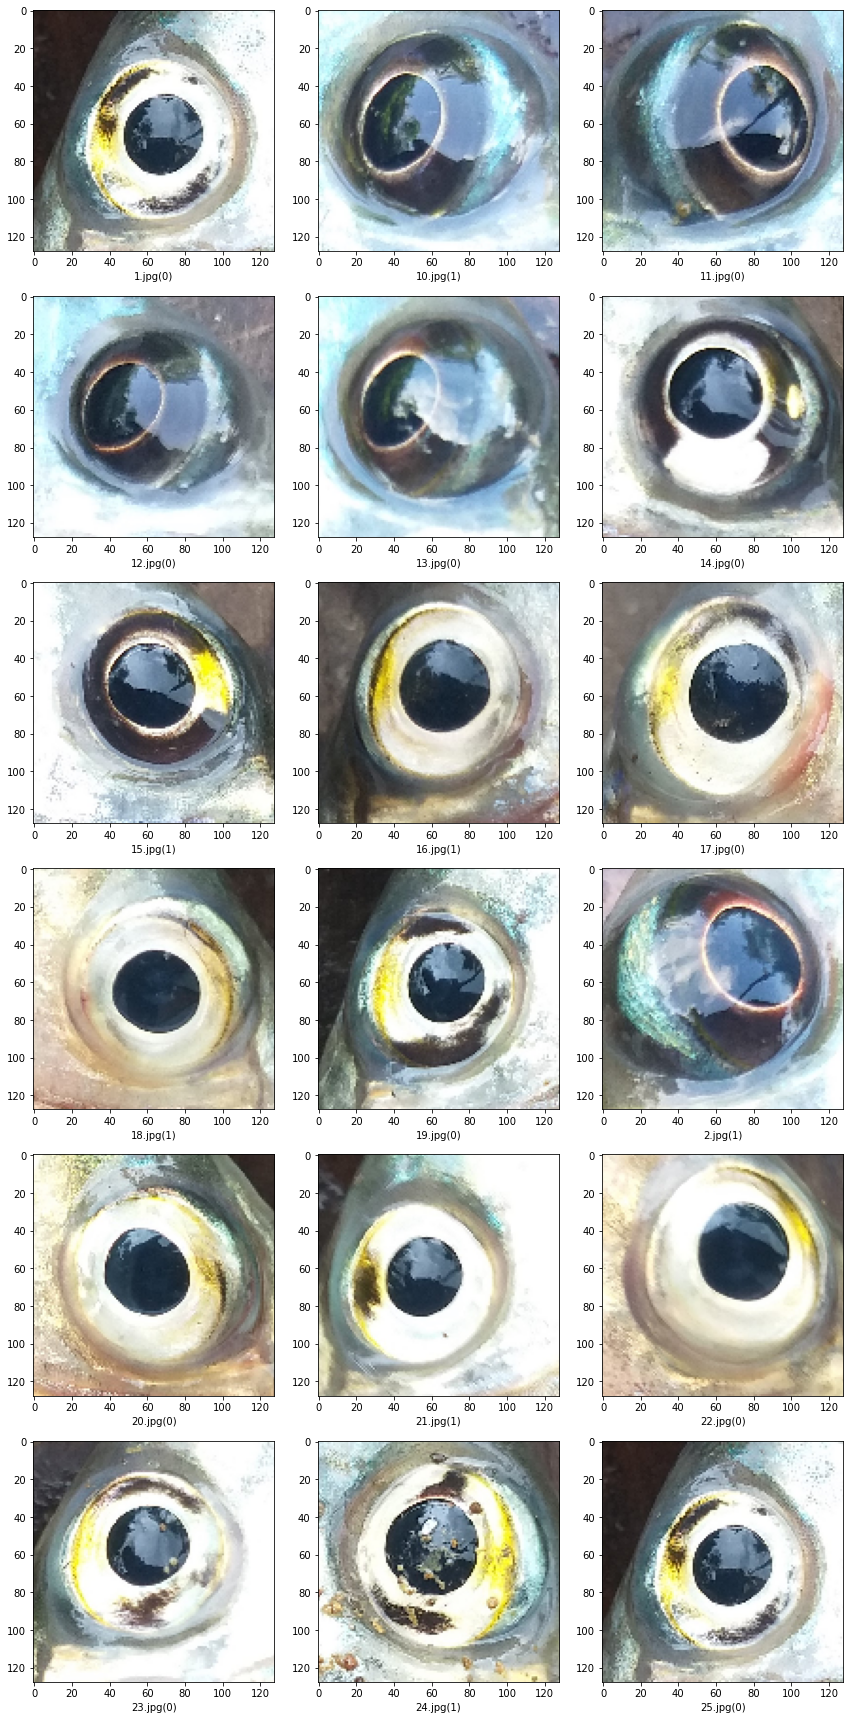

In [178]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("Data/test1/"+filename, target_size=Image_Size)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) +')')
plt.tight_layout()
plt.show()

1 fresh


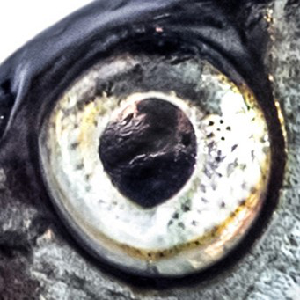

In [181]:
results = {
    0:'notfresh',
    1:'fresh'
}
customimage = "Data/test1/34.jpg"
im=Image.open(customimage)
im=im.resize(Image_Size)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict_classes([im])[0]
print(pred,results[pred])
load_img(customimage, target_size=(300,300))